In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from datasets import Dataset
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch.utils.data import DataLoader

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
data = pd.read_csv(r"Sentiment Analysis for Mental Health\Combined Data.csv")

In [16]:
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [19]:
df = data.drop(columns= ['Unnamed: 0'])

In [ ]:
df = data.dropna(inplace= True)

In [20]:
df.shape

(53043, 2)

In [21]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [24]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [25]:
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

In [26]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

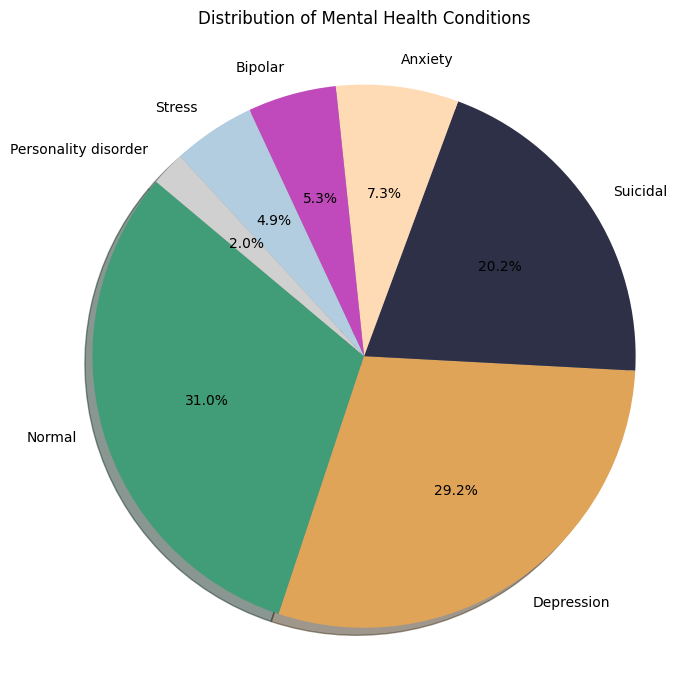

In [27]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

In [28]:
df = df.sample(n=6000,).reset_index(drop= True)

## Data Preprocessing

In [33]:
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    # Convert to lowercase
    statement = statement.lower()

    # Remove special characters (punctuation, non-alphabetic characters)
    statement = re.sub(r'[^\w\s]', '', statement)

    # Remove numbers (optional, depending on your use case)
    statement = re.sub(r'\d+', '', statement)

    # Tokenize the statement (split into words)
    words = statement.split()

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Rejoin words into a cleaned statement
    cleaned_statement = ' '.join(words)

    return cleaned_statement

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\E_Hom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
df['statement'] = df['statement'].apply(clean_statement)

In [36]:
df

,statement,status
0,miss friend elementary middle school,Normal
1,painkillers penicillin four days done shit can...,Suicidal
2,please tell cannot bear need help kill false m...,Suicidal
3,reason niece decided call us basically tattle ...,Stress
4,sorry cannot take anymore everyone would happi...,Suicidal
...,...,...
5995,dealing depressikn hows anyone else make ridin...,Depression
5996,another country right grandmas everyone mean t...,Depression
5997,health anxiety ive noticed last year ive becom...,Anxiety
5998,first little experience dealing anyone depress...,Depression


In [37]:
df.status.value_counts()

status
Normal                  1847
Depression              1760
Suicidal                1205
Anxiety                  435
Bipolar                  322
Stress                   300
Personality disorder     131
Name: count, dtype: int64

### solving imbalance problem

In [39]:
ros = RandomOverSampler(sampling_strategy= 'auto', random_state= 42)

In [40]:
x = df.drop(columns= ['status'])
y = df['status']

x_resampled, y_resampled = ros.fit_resample(x, y)

resampled_df = pd.concat([x_resampled, y_resampled], axis= 1)

d:\projects\env\torch_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
d:\projects\env\torch_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [41]:
resampled_df['status'].value_counts()

status
Normal                  1847
Suicidal                1847
Stress                  1847
Depression              1847
Anxiety                 1847
Bipolar                 1847
Personality disorder    1847
Name: count, dtype: int64

In [42]:
resampled_df


,statement,status
0,miss friend elementary middle school,Normal
1,painkillers penicillin four days done shit can...,Suicidal
2,please tell cannot bear need help kill false m...,Suicidal
3,reason niece decided call us basically tattle ...,Stress
4,sorry cannot take anymore everyone would happi...,Suicidal
...,...,...
12924,know people read whole get ones responsibility...,Suicidal
12925,get sick times talking wantingtokillmyself tel...,Suicidal
12926,possible hanging doorknob,Suicidal
12927,ex broke last december trying stay friends how...,Suicidal


#### Encoding

In [43]:
encoder = LabelEncoder()
resampled_df['label'] = encoder.fit_transform(resampled_df['status'])

In [44]:
resampled_df.head()

,statement,status,label
0,miss friend elementary middle school,Normal,3
1,painkillers penicillin four days done shit can...,Suicidal,6
2,please tell cannot bear need help kill false m...,Suicidal,6
3,reason niece decided call us basically tattle ...,Stress,5
4,sorry cannot take anymore everyone would happi...,Suicidal,6


### Train Test Split

In [45]:
xtrain, xtest, ytrain, ytest = train_test_split(resampled_df['statement'], resampled_df['label'], test_size=0.2, random_state= 42)

In [46]:
max([len(text) for text in resampled_df['statement']])

16329

## Tokenization

In [ ]:
# Specify the directory where you want to download the tokenizer
cache_dir = 'Pre-trained Models'  # Replace with your desired directory

# Load the tokenizer from the pre-trained model and specify the cache directory
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=cache_dir)

# Check if it's loaded successfully
print(tokenizer)

d:\projects\env\torch_env\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\projects\Pre-trained Models\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [48]:
train_encodings = tokenizer(list(xtrain), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(xtest), padding=True, truncation=True, max_length=200)

# Convert to dataset format

In [51]:
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': ytrain.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': ytest.tolist()})

train_dataset[2]

{'input_ids': [101,
  2318,
  2635,
  4200,
  2066,
  2056,
  10047,
  2893,
  4200,
  2123,
  2102,
  2228,
  2428,
  2734,
  4200,
  19294,
  2667,
  2131,
  14667,
  2144,
  2197,
  2095,
  2633,
  3530,
  2165,
  2034,
  13004,
  7483,
  2851,
  2117,
  2851,
  4384,
  3431,
  2664,
  2409,
  2071,
  2202,
  2505,
  2428,
  3431,
  4921,
  2063,
  4384,
  19810,
  4921,
  2063,
  3228,
  2173,
  5092,
  2215,
  2131,
  15345,
  2435,
  2330,
  18269,
  2156,
  2045,
  2015,
  2505,
  4200,
  5699,
  2672,
  4066,
  9898,
  2987,
  2102,
  2941,
  2505,
  3228,
  8275,
  4200,
  2667,
  2156,
  2689,
  8929,
  9727,
  17357,
  2242,
  5683,
  2066,
  2027,
  2890,
  2667,
  4487,
  13102,
  17597,
  20704,
  17299,
  2130,
  2295,
  3924,
  22939,
  26745,
  3366,
  2134,
  2102,
  2393,
  19294,
  2409,
  7568,
  2156,
  2298,
  2066,
  10047,
  19960,
  17872,
  4011,
  2812,
  2064,
  2102,
  2425,
  2052,
  7568,
  2156,
  5335,
  2667,
  3231,
  5064,
  2123,
  2102,
  2113,
  

In [58]:
len(train_dataset['attention_mask'])
# input_ids, attention_mask, labels

10343

## Fine Tune Bert


In [60]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels= len(encoder.classes_), cache_dir=cache_dir)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
# print(model.device)  # Should show "cuda" if it's on the GPU

cuda:0


In [ ]:
training_args = TrainingArguments(
    output_dir="Mental_health_classification_bert_transformer\mental_health_bert_results",
    evaluation_strategy= 'epoch',
    save_strategy= 'epoch',
    learning_rate=2e-5,
    per_device_train_batch_size= 16,
    per_device_eval_batch_size= 16,
    num_train_epochs= 10,
    weight_decay= 0.01,
    logging_dir='Mental_health_classification_bert_transformer\mental_health_bert_logs',
    logging_steps=10,
    lr_scheduler_type= 'linear',
    warmup_steps= 250,
    load_best_model_at_end= True,
    metric_for_best_model= 'eval_loss',
    save_total_limit= 10,
    gradient_accumulation_steps= 5,
    #device="cuda" if torch.cuda.is_available() else "cpu"
    
)

In [91]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [92]:
# train Fine-tuned model
# AcceleratorState._reset_state() # Reset the accelerator state
trainer.train()#resume_from_checkpoint= True)

Epoch,Training Loss,Validation Loss
1,0.253900,0.367696
2,0.169200,0.304808
3,0.179200,0.330410
4,0.121200,0.290268
5,0.060700,0.316602
6,0.027900,0.349029
7,0.032500,0.398734
8,0.014600,0.395562
9,0.004500,0.409052


TrainOutput(global_step=1290, training_loss=0.10185350680420566, metrics={'train_runtime': 1852.5268, 'train_samples_per_second': 55.832, 'train_steps_per_second': 0.696, 'total_flos': 1.055441322819e+16, 'train_loss': 0.10185350680420566, 'epoch': 9.927357032457497})

## Model Evaluation

                      precision    recall  f1-score   support

             Anxiety       0.95      0.98      0.97       327
             Bipolar       0.99      0.99      0.99       396
          Depression       0.79      0.70      0.74       385
              Normal       0.93      0.83      0.87       372
Personality disorder       0.97      1.00      0.99       372
              Stress       0.97      0.99      0.98       373
            Suicidal       0.73      0.83      0.78       361

            accuracy                           0.90      2586
           macro avg       0.90      0.90      0.90      2586
        weighted avg       0.90      0.90      0.90      2586



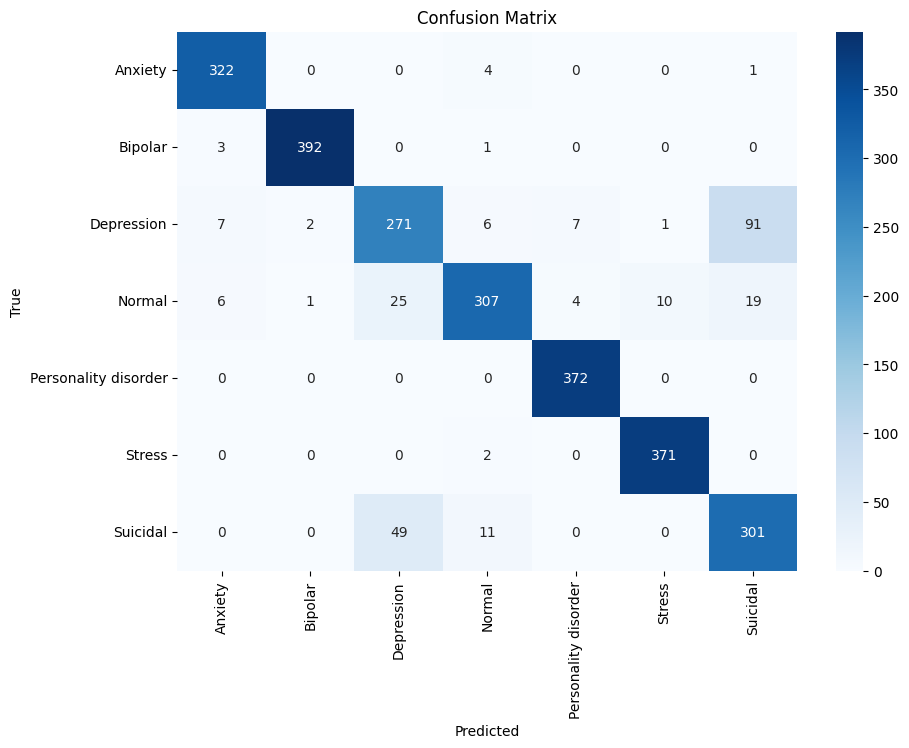

In [93]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print(classification_report(ytest, predicted_labels, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(ytest, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

- The model is performing good with 90% overall accuracy but we could improve performance of depression and suicidal categories.

## Save and Load Model

In [94]:

# Save the trained model and tokenizer
trainer.save_model("mental_status_bert_v2")  # Save the model to the specified directory
tokenizer.save_pretrained("mental_status_bert_v2")  # Save the tokenizer


import pickle

pickle.dump(encoder, open('label_encoder.pkl', 'wb'))

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define the save path
model_path = r"Mental_health_classification_bert_transformer/mental_status_bert_v2"

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load the label encoder
label_encoder = pickle.load(open(r"mental_status_bert_v2/label_encoder.pkl", "rb"))

print("Model, tokenizer, and label encoder loaded successfully!")

Model, tokenizer, and label encoder loaded successfully!


In [99]:
# Detection System (Example)
def detect_anxiety(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]


In [98]:

# Test detection system with a mixture of normal, anxiety, bipolar, depression, suicide, etc.
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up."
]

# Assuming the detect_anxiety function is already defined and takes a sentence as input
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")

Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: Anxiety

Sentence: Lately, I've been on a high, feeling like I can do anything!
Predicted class: Anxiety

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: Depression

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: Depression

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: Depression

Sentence: I had a really good day, spent some time with my friends.
Predicted class: Normal

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: Normal

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: Suicidal

